# Include new row importance and col importance vectors
### SVD ...

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from experiments.train_model import train_model
from datasets.data_loader_UCI import mixup, data_loader
from sklearn.metrics import accuracy_score
from sympy.printing.latex import latex
import sklearn
import lime 
import lime.lime_tabular
import numpy as np

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession


config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
from keras.datasets import mnist
from matplotlib import pyplot
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [5]:
def evaluate_model(dataX, dataY, n_folds=5, define_model=None, batch_size=5, epochs=50):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
    return model, scores, histories


def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        pyplot.title('Cross Entropy Loss')
        pyplot.plot(histories[i].history['loss'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
    pyplot.show()

    
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    pyplot.boxplot(scores)
    pyplot.show()
    

def run_test_harness(load_dataset=None, 
                         define_model=None,
                            folds=2,
                            batch_size = 32,
                            epochs = 50):
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    
    # evaluate model
    model, scores, histories = evaluate_model(trainX, trainY, 
                                                n_folds=folds, 
                                                define_model = define_model,
                                                 batch_size=batch_size,
                                                 epochs=epochs)
    # learning curves
    summarize_diagnostics(histories)
    # summarize estimated performance
    summarize_performance(scores)

    return model

class CModel():
    def __init__(self, model):
        self.model = model
    def predict(self, x):
        return np.argmax(self.model.predict(x), 1)

In [13]:

def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm


def load_mnist():
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    trainX = trainX[..., None]
    testX  = testX[..., None]
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    return trainX, trainY, testX, testY



# define cnn model
def define_mnist_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# # define cnn model
# def define_mnist_model():
# 	model = Sequential()
# 	model.add(Dense(512, activation='relu', kernel_initializer='he_uniform', input_shape=(784,)))
# 	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
# 	model.add(Dense(10, activation='softmax'))
# 	# compile model
# 	opt = SGD(lr=0.01, momentum=0.9)
# 	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# 	return model

> 98.492
> 98.742
> 98.617
> 98.942
> 98.925


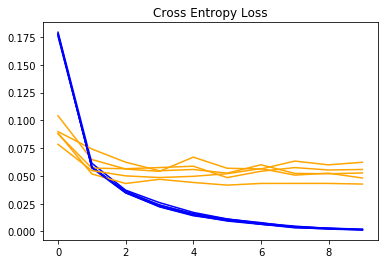

Accuracy: mean=98.743 std=0.174, n=5


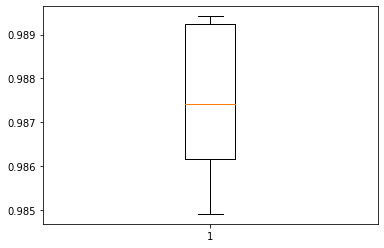

In [15]:
model = run_test_harness(load_mnist,
                        define_mnist_model,
                        folds = 5,
                        batch_size = 25,
                        epochs = 10)

In [40]:
trainX, trainY, testX, testY = load_mnist()
trainX.shape

(60000, 28, 28, 1)

In [ ]:
from symbolic_pursuit.classification2D import SymbolicClassifier2D

symbolic_model = SymbolicClassifier2D(verbosity=True,
                                   maxiter=10,
                                   nclasses=10,
                                   loss_tol=1.0e-1)
symbolic_model.fit(model.predict, trainX[:30].reshape(30, 28, 28))

Model created with the following hyperparameters :
 loss_tol=0.1 
 ratio_tol=0.9 
 maxiter=10 
 eps=1e-05 
 random_seed=42
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Now working on term number  1 .
Now working on hyperparameter tree number  1 .
Optimization terminated successfully.
         Current function value: 4.133670
         Iterations: 0
         Function evaluations: 565
         Gradient evaluations: 1
basinhopping step 0: f 4.13367
Optimization terminated successfully.
         Current function value: 4.141395
         Iterations: 2
         Function evaluations: 3390
         Gradient evaluations: 6
basinhopping step 1: f 4.1414 trial_f 4.1414 accepted 1  lowest_f 4.13367
